In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
7,913 cases (7 day average) as of Fri 18 Jun, +306.7 since Thu 17 Jun
183 hospitalised (7 day average) as of Mon 21 Jun, -0.6 since Sun 20 Jun
9 died (7 day average) as of Fri 18 Jun, +0.9 since Thu 17 Jun


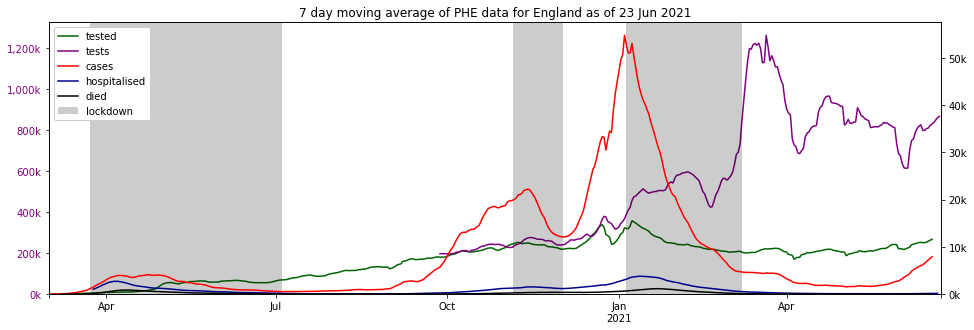

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

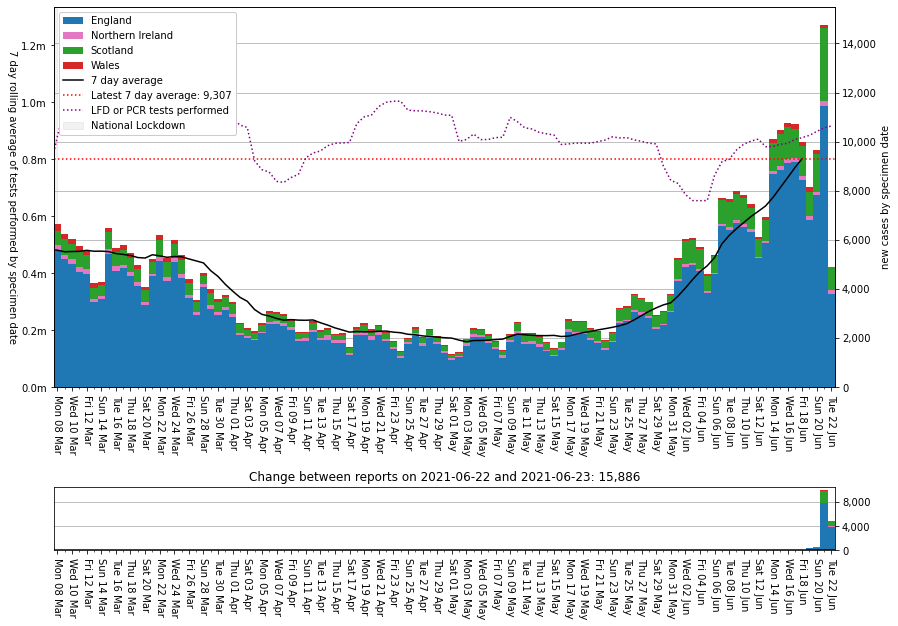

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

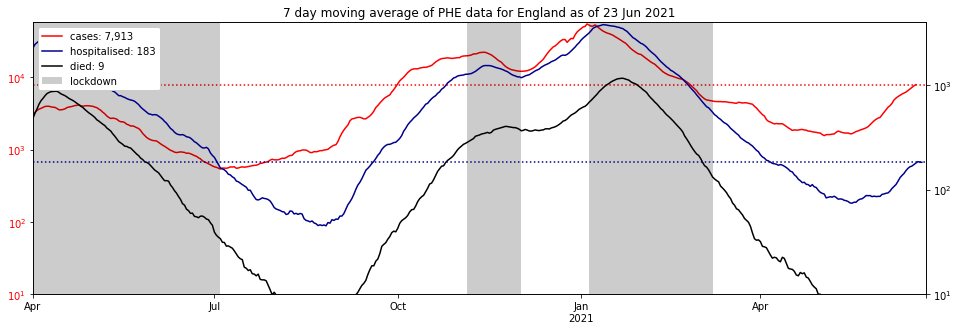

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

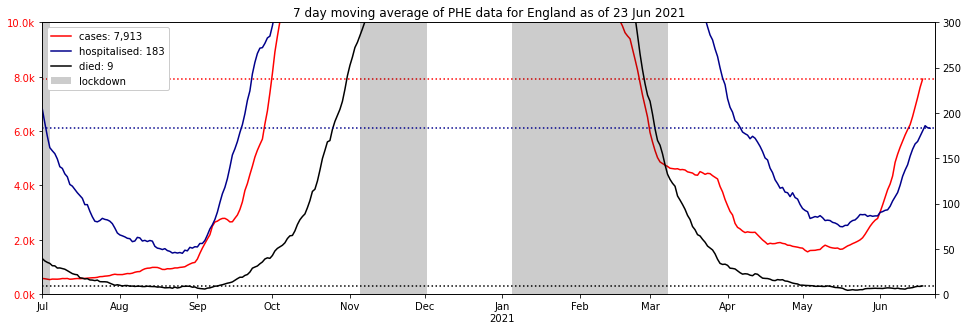

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=10_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=300)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,22 Jun 21,"+26,745,666","+36,377,425","+26,745,666","+210,730","+275,647","+210,730"
Northern Ireland,22 Jun 21,"+823,908","+1,147,153","+823,908","+6,730","+3,930","+6,730"
Scotland,22 Jun 21,"+2,617,450","+3,681,620","+2,617,450","+14,697","+17,049","+14,697"
Wales,22 Jun 21,"+1,553,091","+2,242,482","+1,553,091","+18,718","+3,211","+18,718"


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,26745666.0,36377425.0,9631759.0,56286961,47.516628,17.111883,35.371489
1,Northern Ireland,N92000002,823908.0,1147153.0,323245.0,1893667,43.508600,17.069791,39.421609
2,Scotland,S92000003,2617450.0,3681620.0,1064170.0,5463300,47.909688,19.478520,32.611791
3,Wales,W92000004,1553091.0,2242482.0,689391.0,3152879,49.259455,21.865444,28.875101


'partial: 43,448,680 (65.0%), full: 31,740,115'

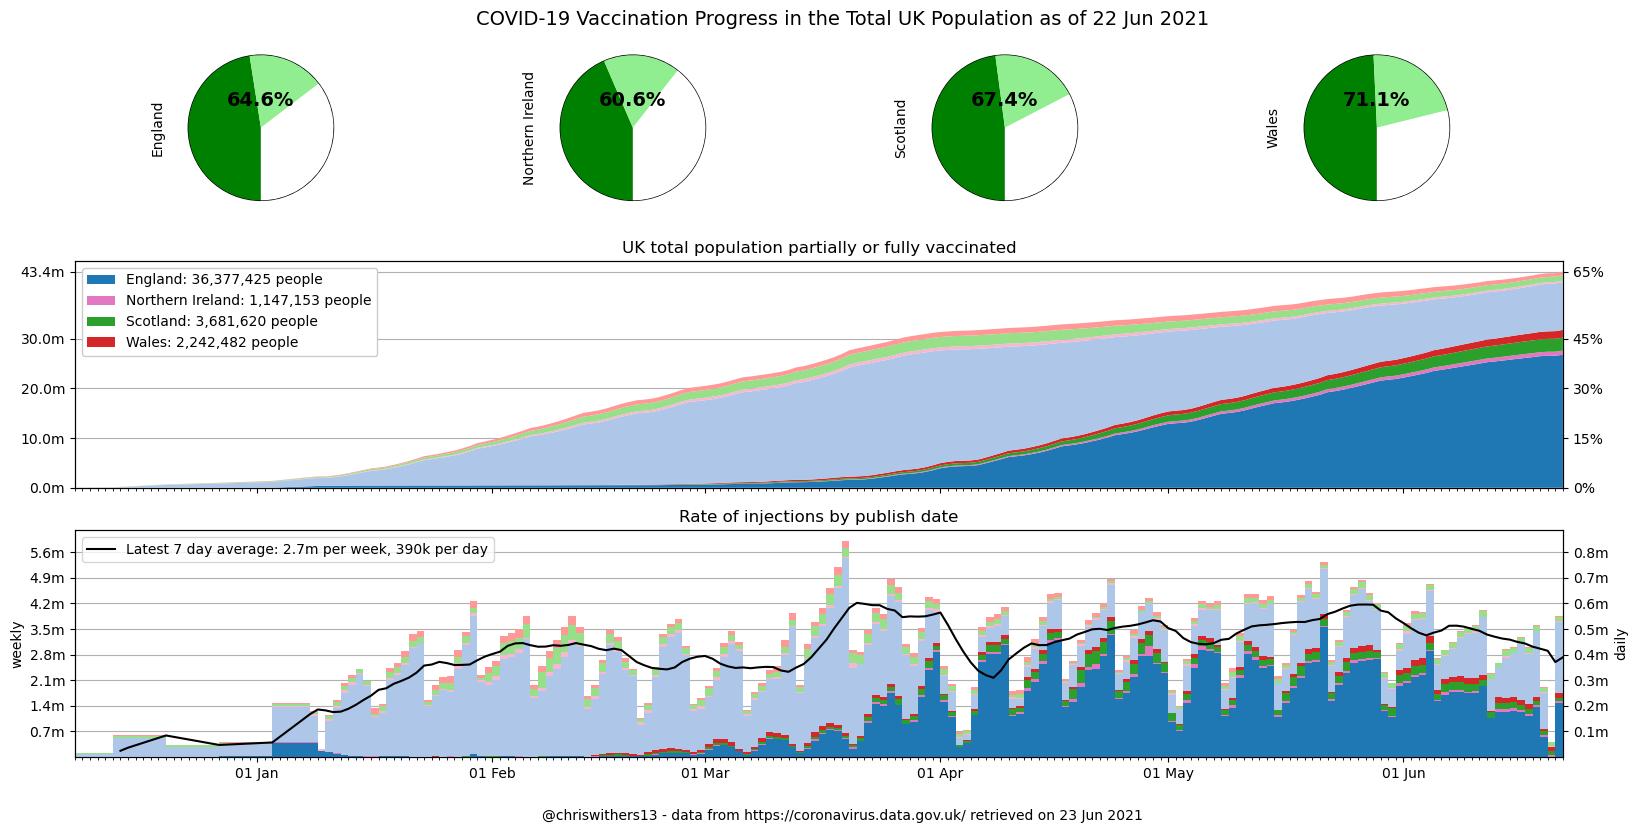

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

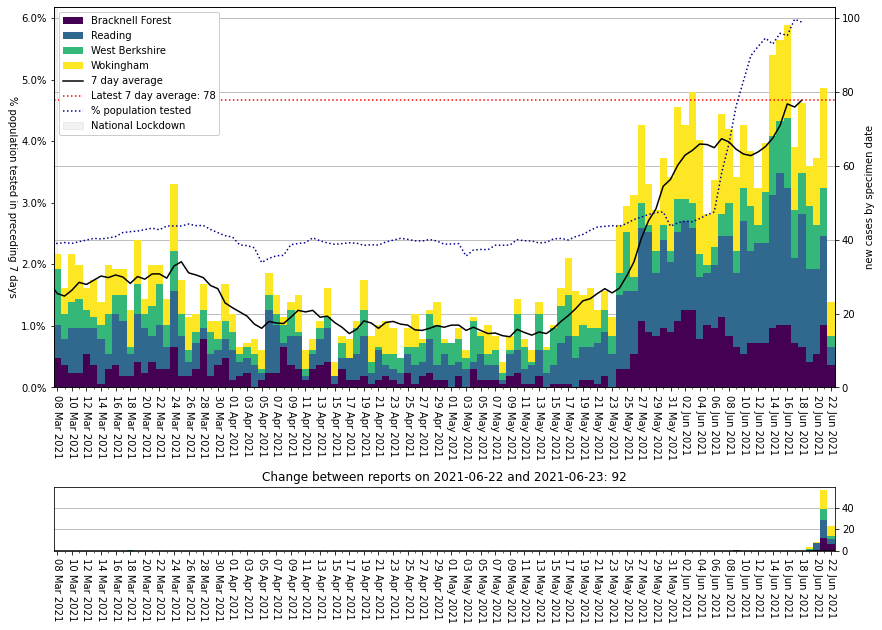

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1], lines=unique_people_tested)

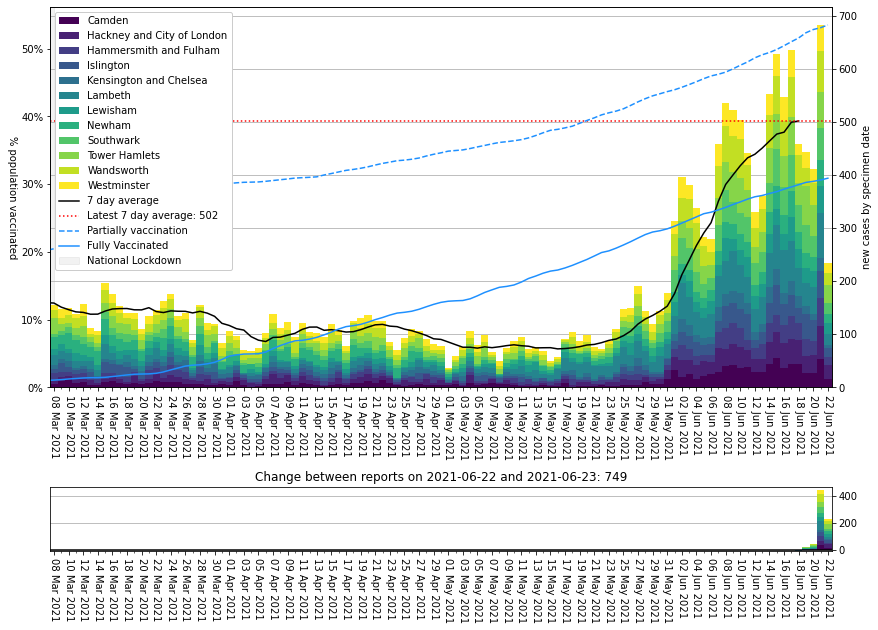

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000120,Hyndburn,434.337327,352.0,2021-06-22
E06000008,Blackburn with Darwen,410.164600,614.0,2021-06-22
S12000010,East Lothian,380.054160,407.0,2021-06-22
S12000042,Dundee City,365.657648,546.0,2021-06-22
E08000003,Manchester,347.286283,1920.0,2021-06-22
E07000117,Burnley,330.634278,294.0,2021-06-22
E07000124,Ribble Valley,328.471948,200.0,2021-06-22
E07000125,Rossendale,324.557231,232.0,2021-06-22
S12000019,Midlothian,317.975341,294.0,2021-06-22


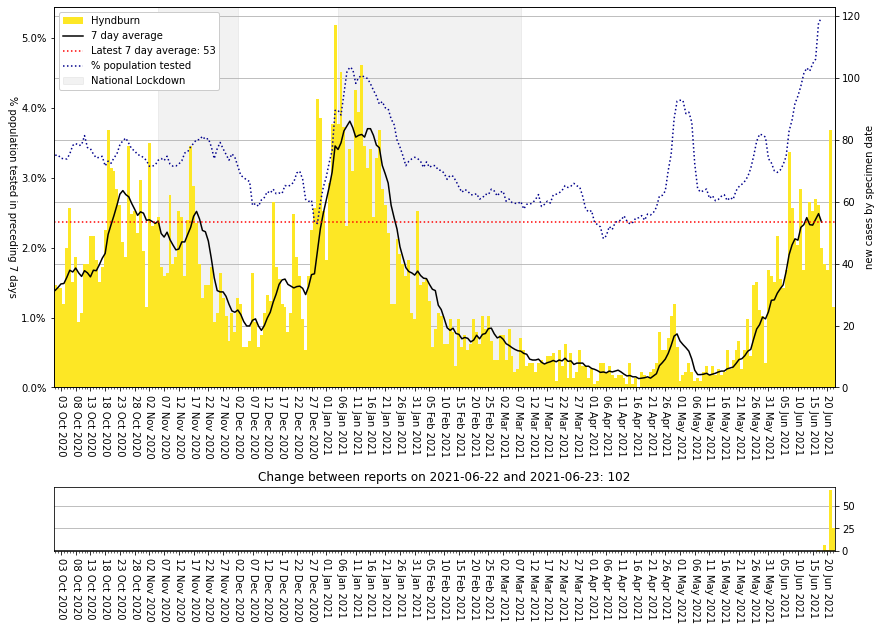

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000003,Manchester,347.286283,1920.0,2021-06-22
E08000035,Leeds,227.954999,1808.0,2021-06-22
S12000036,City of Edinburgh,312.994114,1643.0,2021-06-22
E08000025,Birmingham,123.137178,1406.0,2021-06-22
S12000049,Glasgow City,201.699520,1277.0,2021-06-22
E08000012,Liverpool,252.589139,1258.0,2021-06-22
E06000047,County Durham,222.413383,1179.0,2021-06-22
E08000010,Wigan,282.661214,929.0,2021-06-22
E08000021,Newcastle upon Tyne,300.178324,909.0,2021-06-22


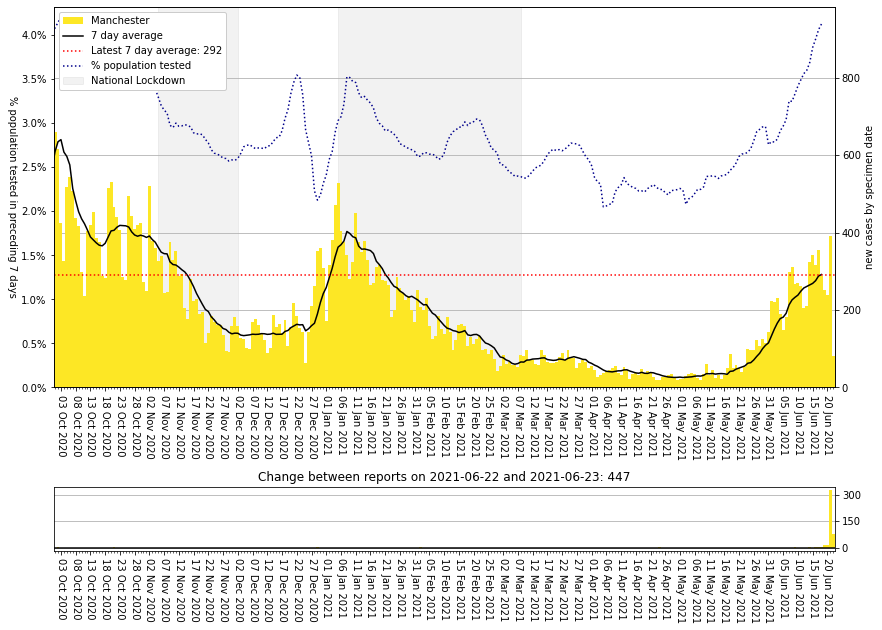

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 2.5
phe_max = 0.5

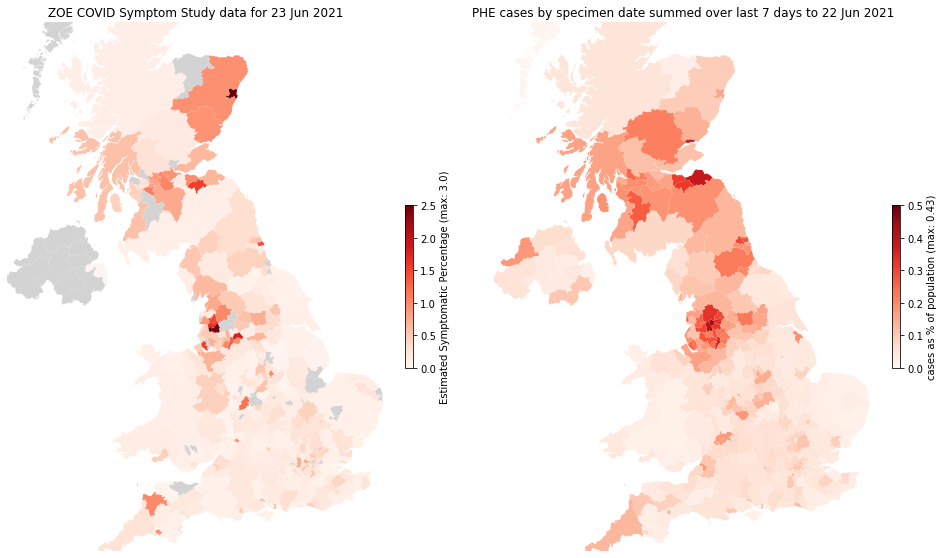

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...